In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/Superstore.csv', encoding='latin1')
df.to_csv('datasets/Superstore_utf8.csv', encoding='utf-8', index=False)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Ship Year'] = df['Ship Date'].dt.year
df['Ship Month'] = df['Ship Date'].dt.month
df['Ship Day'] = df['Ship Date'].dt.day

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']
numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(df)

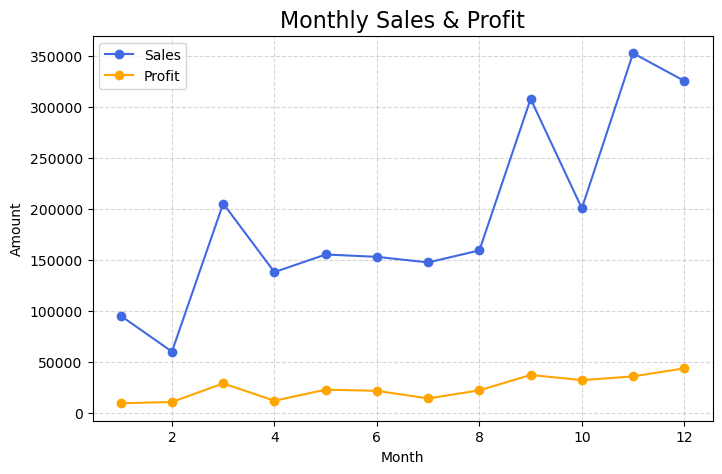

In [5]:
month_stats = df.groupby('Order Month')[['Sales', 'Profit']].sum().sort_index()

plt.figure(figsize=(8, 5))
plt.plot(month_stats.index, month_stats['Sales'], marker='o', label='Sales', color='royalblue')
plt.plot(month_stats.index, month_stats['Profit'], marker='o', label='Profit', color='orange')

plt.title('Monthly Sales & Profit', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Amount')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

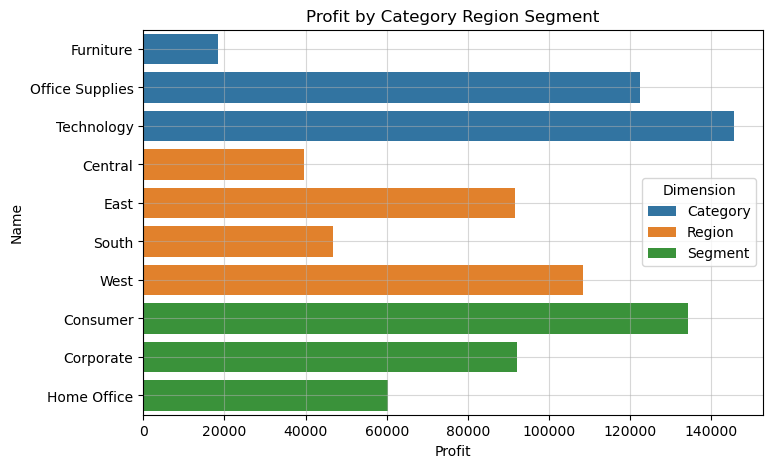

In [6]:
cat_profit = df.groupby('Category')['Profit'].sum().reset_index()
cat_profit['Dimension'] = 'Category'
cat_profit.rename(columns={'Category': 'Name'}, inplace=True)

reg_profit = df.groupby('Region')['Profit'].sum().reset_index()
reg_profit['Dimension'] = 'Region'
reg_profit.rename(columns={'Region': 'Name'}, inplace=True)

seg_profit = df.groupby('Segment')['Profit'].sum().reset_index()
seg_profit['Dimension'] = 'Segment'
seg_profit.rename(columns={'Segment': 'Name'}, inplace=True)

profit_structure = pd.concat([cat_profit, reg_profit, seg_profit], ignore_index=True)

plt.figure(figsize=(8, 5))
sns.barplot(x='Profit', y='Name', hue='Dimension', data=profit_structure)
plt.title('Profit by Category Region Segment')
plt.grid(True, alpha=0.5)
plt.show()

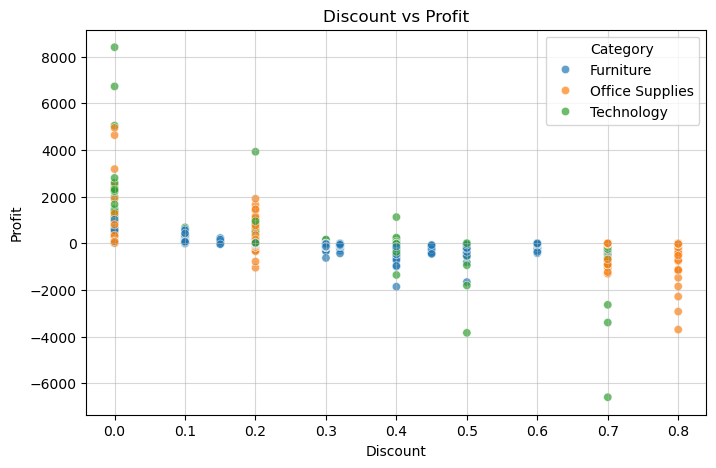

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Discount', y='Profit', data=df, hue='Category', alpha=0.7)
plt.title('Discount vs Profit')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.grid(True, alpha=0.5)
plt.show()

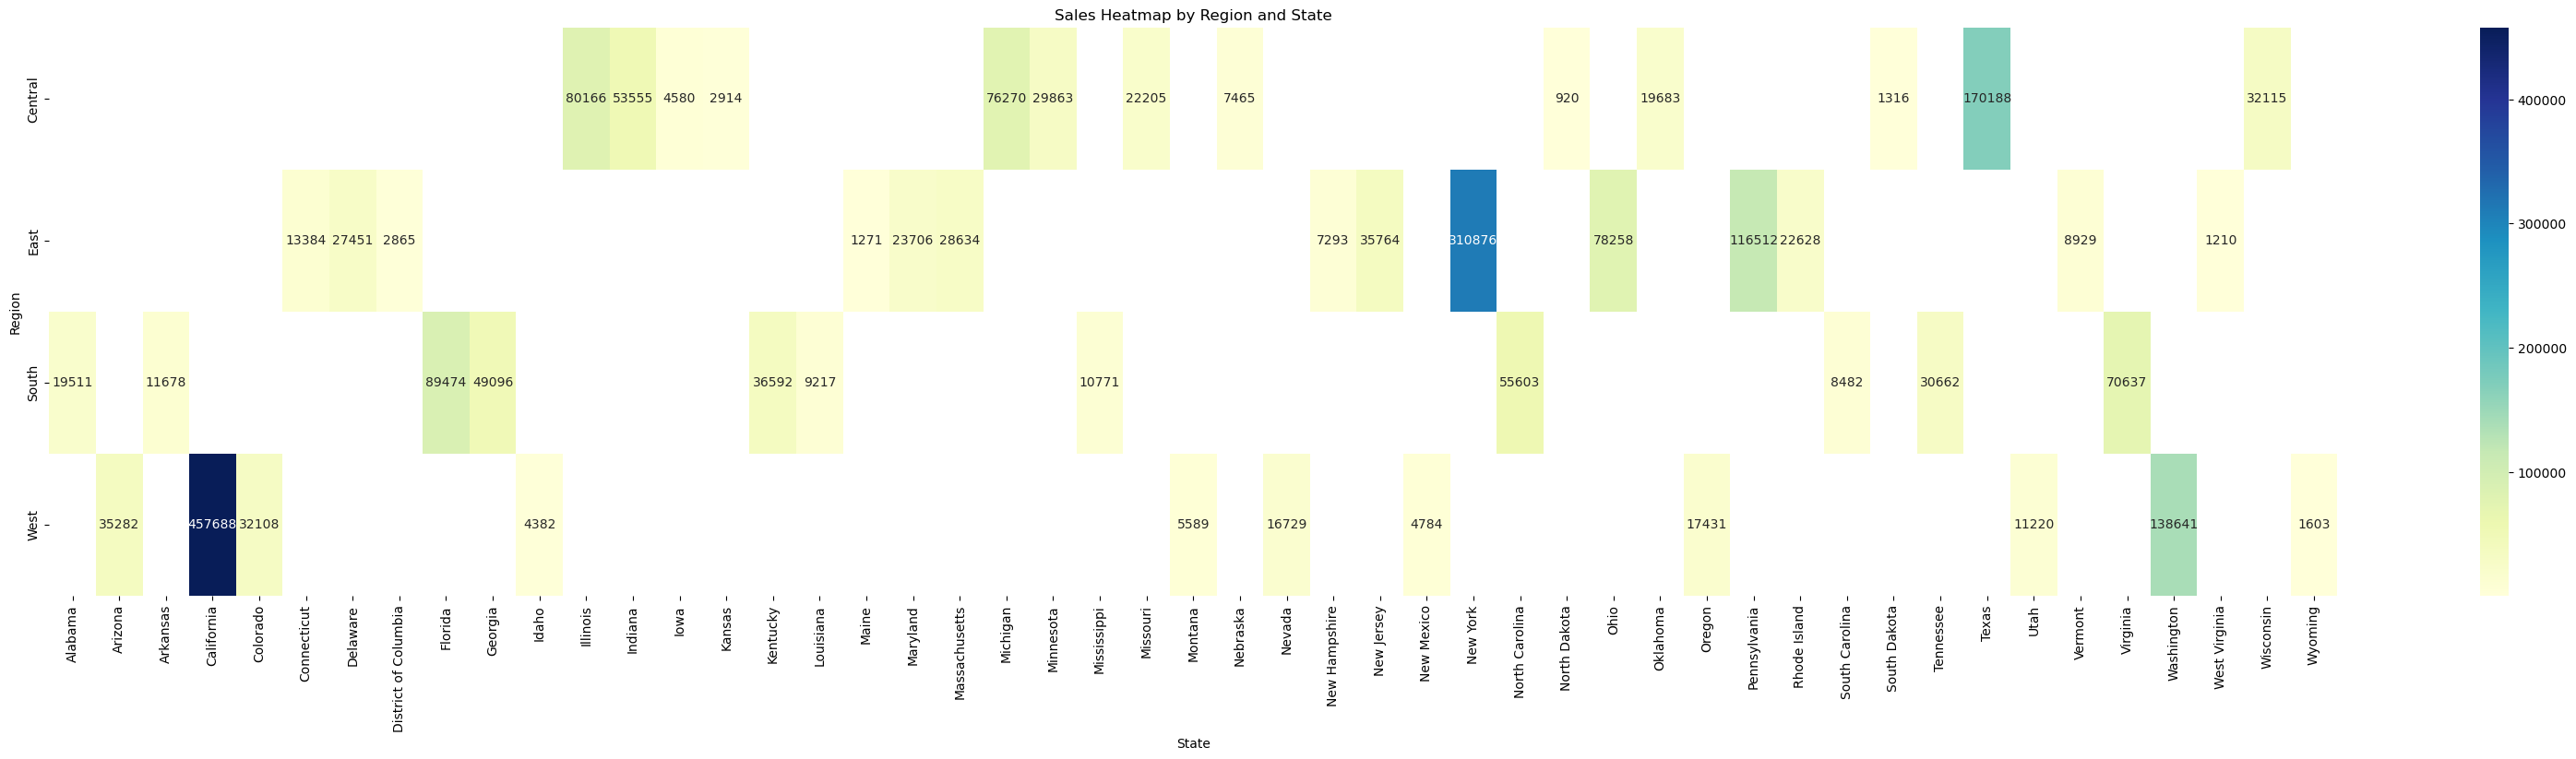

In [8]:
region_state = df.pivot_table(index='Region', columns='State', values='Sales', aggfunc='sum')

plt.figure(figsize=(40, 8))
sns.heatmap(region_state, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Sales Heatmap by Region and State')
plt.show()

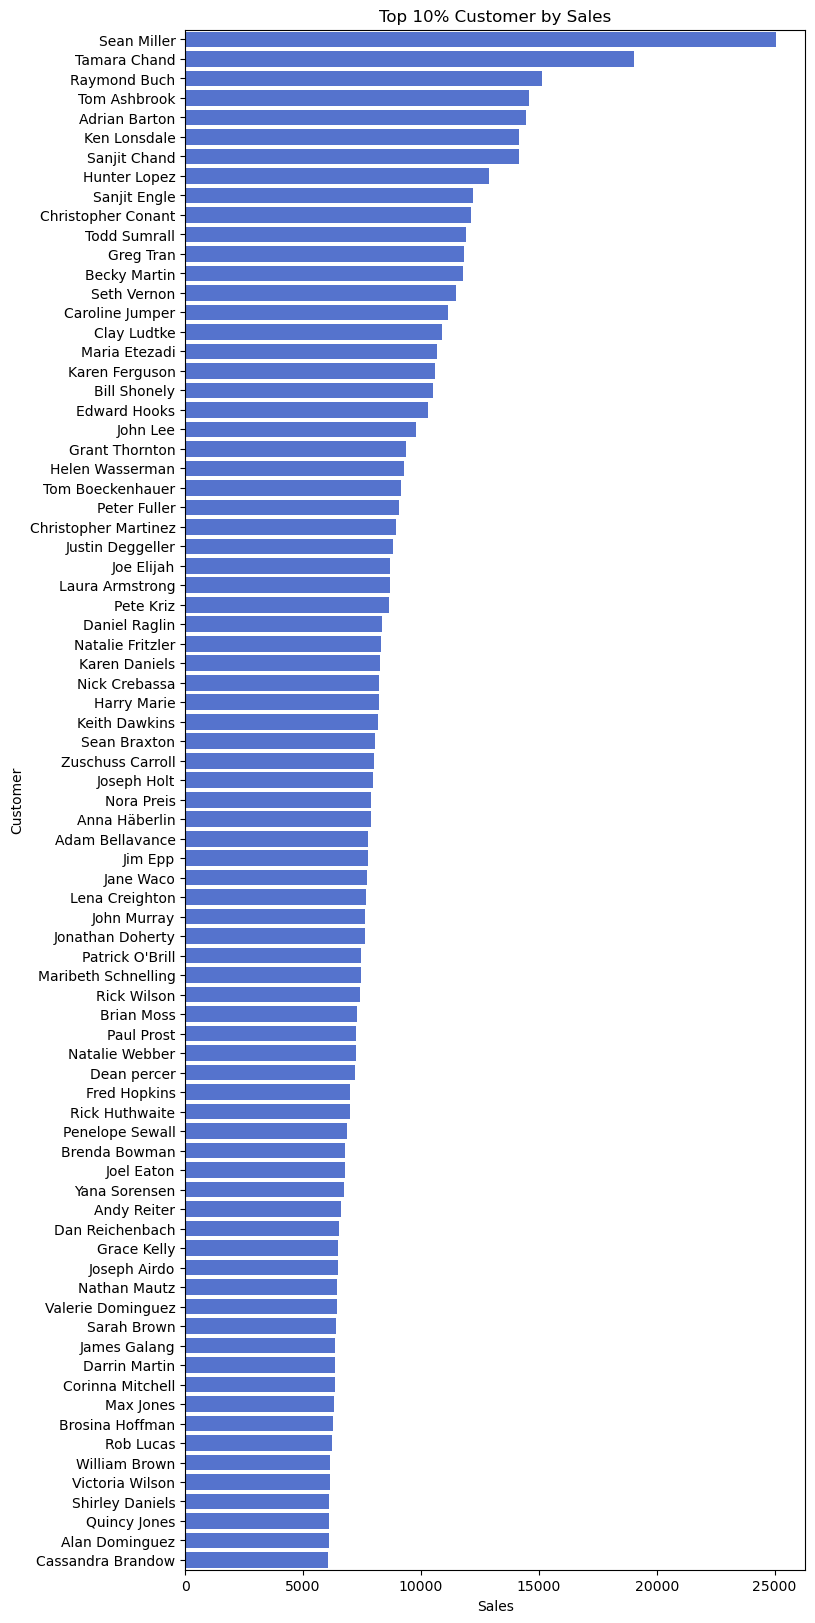

In [9]:
customer_sales = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False)
top_10pct_customers = customer_sales[:int(0.1*len(customer_sales))]

plt.figure(figsize=(8, 20))
sns.barplot(x=top_10pct_customers, y=top_10pct_customers.index, color='royalblue')
plt.title('Top 10% Customer by Sales')
plt.xlabel('Sales')
plt.ylabel('Customer')
plt.show()

            Order ID  Actual Sales  Predicted Sales
3125  CA-2015-121720       563.808       563.709141
1441  CA-2017-128160        36.672        36.641100
4510  CA-2016-119935        37.300        37.286889
39    CA-2015-117415       212.058       211.980483
4509  CA-2017-167003       171.288       171.160474
Sales RMSE: 242.87306963484886


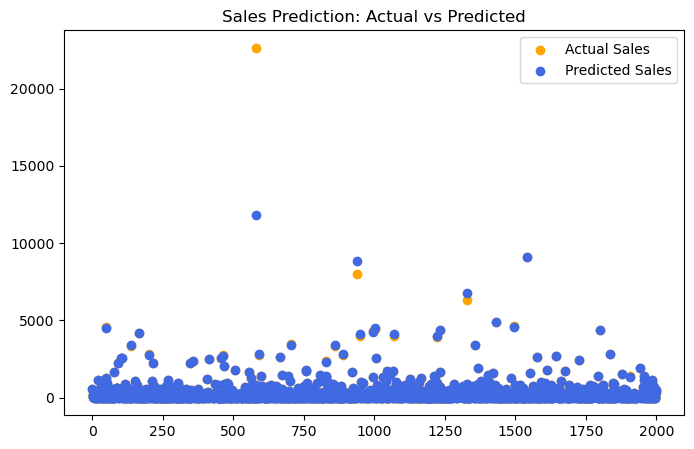

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

X = X_processed
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

indices = y_test.index

regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
regressor.fit(X_train, y_train)
regressor_pred = regressor.predict(X_test)

predictions = pd.DataFrame({
    'Order ID': df.loc[indices, 'Order ID'],
    'Actual Sales': y_test,
    'Predicted Sales': regressor_pred
})

print(predictions.head())
print('Sales RMSE:', mean_squared_error(y_test, regressor_pred, squared=False))

joblib.dump(regressor, 'sales_model.pkl')

plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test)), y_test, label='Actual Sales', color='orange')
plt.scatter(range(len(regressor_pred)), regressor_pred, label='Predicted Sales', color='royalblue')
plt.title('Sales Prediction: Actual vs Predicted')
plt.legend()
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

y_loss = (df['Profit'] < 0).astype(int)
X_train, y_test, y_train, y_test = train_test_split(X, y_loss, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
classifier.fit(X_train, y_train)
classifier_pred = classifier.predict(X_test)

predictions_loss = pd.DataFrame({
    'Order ID': df.loc[y_test.index, 'Order ID'],
    'Actual Loss': y_test.values,
    'Predicted Loss': classifier_pred
})

print(predictions_loss.head())
print(classification_report(y_test, classifier_pred))

joblib.dump(classifier, 'loss_model.pkl')

            Order ID  Actual Loss  Predicted Loss
3125  CA-2015-121720            0               0
1441  CA-2017-128160            0               0
4510  CA-2016-119935            0               0
39    CA-2015-117415            1               1
4509  CA-2017-167003            1               1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1636
           1       1.00      1.00      1.00       363

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999



['loss_model.pkl']

C:\Users\q3056\.conda\envs\hands-on-ml-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
C:\Users\q3056\AppData\Local\Temp\ipykernel_82812\616062237.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\q3056\.conda\envs\hands-on-ml-env\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


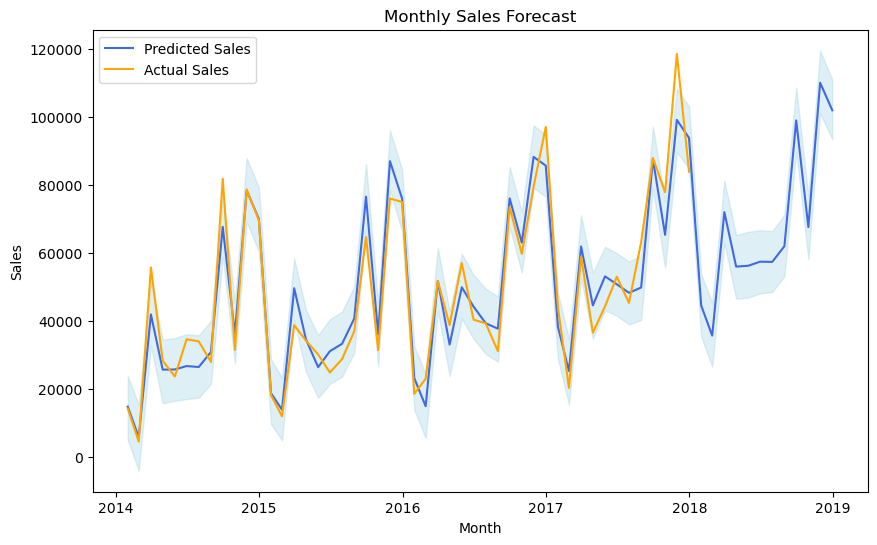

In [12]:
from prophet import Prophet

monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
monthly_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'}, inplace=True)

ts_model = Prophet()
ts_model.fit(monthly_sales)

future = ts_model.make_future_dataframe(periods=12, freq='M')
forecast = ts_model.predict(future)

plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', color='royalblue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4)
plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='orange')
plt.title('Monthly Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

     Customer Name  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0    Aaron Bergman      416          6   886.156        1        1        1   
1    Aaron Hawkins       13         11  1744.700        5        3        3   
2   Aaron Smayling       89         10  3050.692        3        2        4   
3  Adam Bellavance       55         18  7755.620        3        4        5   
4        Adam Hart       35         20  3250.337        4        5        4   

  RFM_Segment  RFM_Score     Segment  
0         111          3   Low Value  
1         533         11   Mid Value  
2         324          9   Mid Value  
3         345         12  High Value  
4         454         13  High Value  


C:\Users\q3056\AppData\Local\Temp\ipykernel_82812\648194802.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm, order=['High Value', 'Mid Value', 'Low Value'], palette='viridis')


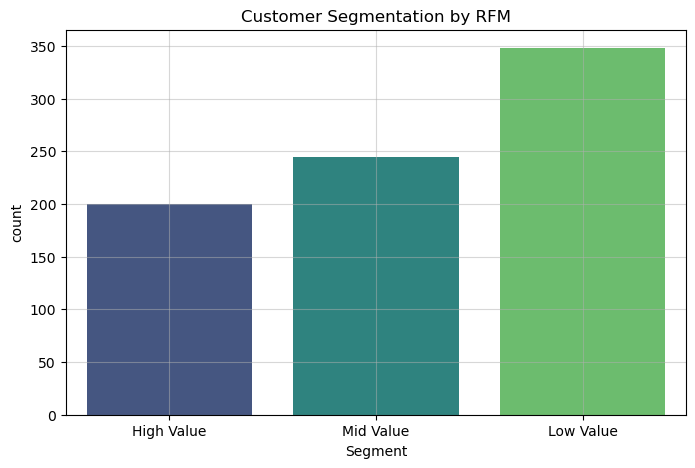

In [13]:
from datetime import datetime

df['Order Date'] = pd.to_datetime(df['Order Date'])

snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer Name').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum'
}).reset_index()

rfm.columns = ['Customer Name', 'Recency', 'Frequency', 'Monetary']

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

def segment_customer(score):
    if score >= 12:
        return 'High Value'
    elif score >= 9:
        return 'Mid Value'
    else:
        return 'Low Value'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

print(rfm.head())

plt.figure(figsize=(8, 5))
sns.countplot(x='Segment', data=rfm, order=['High Value', 'Mid Value', 'Low Value'], palette='viridis')
plt.title('Customer Segmentation by RFM')
plt.grid(True, alpha=0.5)
plt.show()

In [14]:
forecast.to_csv('monthly_sales_forecast.csv', index=False)
predictions.to_csv('sales_predictions.csv', index=False)
predictions_loss.to_csv('loss_predictions.csv', index=False)
rfm.to_csv('customer_clusters.csv', index=False)